In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import chromATAC as ca
from chromATAC.integrated import IntData
from pycirclize import Circos
from pycirclize.utils import ColorCycler
import collections
import matplotlib.pyplot as plt
from pathlib import Path

from pycirclize import Circos
from pycirclize.utils import load_eukaryote_example_dataset

In [3]:
from chromATAC.pl import StackPlot

In [4]:
parent_dir = '/Users/mossishahi/Code/lupien/IntData'

In [5]:
os.chdir(parent_dir)

In [6]:
def Clustered_TEs(chromosome_layer, **kwargs):
    resolution = kwargs.get('resolution')
    conditions = {}
    annotations = {}
    resolution = kwargs.get('resolution')
    ann = {0:'TE with no defined CORTE in any chromosome', 1:'TE with defined CORTEs'}
    for chr in range(1, 25):
        idx = np.array([i.split('>')[-1] for i in ind.chr.layers[resolution]['TEs']['index'][chr]])
        conditions[chr] = np.array([int(i in idx) for i in chromosome_layer['index'][chr]])
        annotations[chr] = ann
    return conditions, annotations

def get_cancertype(chromosome_layer, **kwargs):
    conditions = {}
    annotations = {}
    resolution=kwargs.get('resolution')
    ann = {i:v for i, v in enumerate(tcga_met[' Project'].apply(lambda x:x.split('TCGA-')[-1]).unique())}
    mapping = {v:i for i, v in enumerate(tcga_met[' Project'].apply(lambda x:x.split('TCGA-')[-1]).unique())}
    for chr in ca.info.CHROMOSOMES['numericals'].values():
        samples = chromosome_layer['index'][chr]
        conditions[chr] = [mapping[i.split('_')[0].split('>')[-1]] for i in ind.chr.layers[resolution]['TCGA']['index'][chr]]
        annotations[chr] = ann
    return conditions, annotations
    
def CTeCore_filter(chromosome_layer, **kwargs):
    conditions = {}
    annotations = {}    
    ann = {0:'TEs with No Significant Difference between #Cores and #Elements in this Chromosome', 1:'TEs with Significant Difference between #Cores and #Elements in this Chromosome'}
    index = kwargs.get('index')
    test_res = kwargs.get('test_res')
    maj = kwargs.get('majority', 3)
    for chr in range(1, 25):
        idx = np.array([i.split('>')[-1] for i in index[test_res[:, chr-1]>=maj]])
        conditions[chr] = np.array([int(i.split('>')[-1] in idx) for i in chromosome_layer['index'][chr]])
        annotations[chr] = ann
    return conditions, annotations

def GTeCore_filter(genome_layer, **kwargs):
    conditions = {}
    annotations = {}
    ann = {0:'TEs with No Significant Difference between #Cores and #Elements in this Chromosome', 1:'TEs with Significant Difference between #Cores and #Elements in this Chromosome'}
    index = kwargs.get('index')
    test_res = kwargs.get('test_res')
    maj = kwargs.get('majority', 3)
    for chr in range(1, 25):
        idx = np.array([i.split('>')[-1] for i in index[test_res[:, chr-1]>=maj]])
        conditions[chr] = np.array([int(i.split('>')[-1] in idx) for i in genome_layer['index']])
        annotations[chr] = ann
    return conditions, annotations

def save_correlation(omic, layers, resolution, chr='all', path=".", cmp_method='sim'):
    metrs = ['score', 'pvalue']
    if chr=='all':
        chr=ca.info.CHROMOSOMES['names']
    if not isinstance(chr, list):
        chr = [chr]
    for c in chr:
        path = os.path.join(path, cmp_method+f'/{c}')
        if not os.path.exists(path):
            os.makedirs(path)
        for m in metrs:
            for k, v in omic.layers[resolution]['co'][tuple(sorted(set(layers)))][cmp_method][c][m].items():
                v.to_csv(f'{path}/{c}_{k}_{m}.csv')
def tcga_mapping(name):
    return f"{tcga_met.iloc[np.where([i in name for i in tcga_met['File Name'].apply(lambda x: x.split('_')[0].split('-')[-1])])[0]][' Project'].apply(lambda x:x.split('TCGA-')[-1]).values[0]}_{name}"

### TE and COTEs

In [7]:
ind = IntData()

ind.add_layer("TEs", input='./data/V2-TEs/TEs', index_mapper=lambda x: x.split("_Merged.bed")[0])
ind.add_layer("CoTEs", input='./data/V2-TEs/CoTEs/', index_mapper=lambda x: x.split("_Merged.bed")[0])

loading files from: ./data/V2-TEs/TEs


100%|█████████████████████████████████████████████████████████████████████████████████| 976/976 [00:09<00:00, 103.12it/s]


loading files from: ./data/V2-TEs/CoTEs/


100%|████████████████████████████████████████████████████████████████████████████████| 458/458 [00:00<00:00, 1177.81it/s]


In [8]:
intogens = pd.read_csv('./data/cancer_drivers/integrated_Unfiltered_drivers.tsv', sep='\t', header=0, index_col=0)
intogens

,SYMBOL,TRANSCRIPT,COHORT,CANCER_TYPE,MUTATIONS,SAMPLES_COHORT,ALL_METHODS,SIG_METHODS,QVALUE_COMBINATION,QVALUE_CGC_COMBINATION,...,OR_WARNING,WARNING_ARTIFACT,KNOWN_ARTIFACT,NUM_PAPERS,WARNING_ENSEMBL_TRANSCRIPTS,DRIVER,FILTER,gene.chr,gene.start,gene.end
0,A1CF,ENST00000395489,HARTWIG_WGS_ANSC_2020,ANSC,2.0,21.0,cbase,cbase,0.095952,0.560607,...,False,False,False,4.0,False,False,No driver,chr10,50799409.0,50885675.0
1,A1CF,ENST00000395489,CBIOP_WXS_SKCM_BROAD,MEL,5.0,88.0,oncodriveclustl,combination,0.017861,0.020904,...,False,False,False,4.0,False,True,Warning expression,chr10,50799409.0,50885675.0
2,A2M,ENST00000318602,CPTAC_WXS_COAD_2020,COAD,6.0,103.0,oncodriveclustl,combination,0.096258,NaN,...,False,False,False,0.0,False,False,No driver,chr12,9067664.0,9116229.0
3,A2M,ENST00000318602,HARTWIG_WGS_CSCC_2020,CSCC,2.0,7.0,"oncodrivefml,cbase",combination,0.121961,NaN,...,False,False,False,0.0,False,False,No driver,chr12,9067664.0,9116229.0
4,A2M,ENST00000318602,ICGC_WGS_LMS_LMS_FR_2019,LMS,2.0,67.0,cbase,cbase,0.054135,NaN,...,False,False,False,0.0,False,False,No driver,chr12,9067664.0,9116229.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22197,ZXDB,ENST00000374888,CBIOP_WXS_PRAD_MSKCC_DCFI_2018_MET,PRAD,4.0,333.0,smregions,combination,0.067531,NaN,...,False,False,False,0.0,False,False,No driver,chrX,57592011.0,57597477.0
22198,ZZEF1,ENST00000381638,TCGA_WXS_MGCT,MGCT,3.0,144.0,smregions,combination,0.000302,NaN,...,False,False,False,0.0,False,False,No driver,chr17,4004445.0,4143030.0
22199,ZZEF1,ENST00000381638,OTHER_WGS_PRAD_CPGEA_2021,PRAD,4.0,208.0,smregions,combination,0.116364,NaN,...,False,False,False,0.0,False,False,No driver,chr17,4004445.0,4143030.0
22200,ZZZ3,ENST00000370801,CGCI_WGS_BL_2020,BL,2.0,72.0,oncodrivefml,combination,0.003092,NaN,...,False,False,False,0.0,False,False,No driver,chr1,77562416.0,77683419.0


In [9]:
intogens.fillna(0.0, inplace=True)
c7_intogenes = intogens[intogens['gene.chr']=='chr7']
c7_intogenes_driver = c7_intogenes[c7_intogenes.DRIVER]
c7_intogenes_notdriver = c7_intogenes[~c7_intogenes.DRIVER]

In [10]:
def mutation_color_map(n_mutations):
    if n_mutations>50:
        return 'red'
    else:
        return 'orange'

In [29]:
driver_rectangles = [(row['gene.start'], row['gene.end'], int(row['MUTATIONS'])) for _,row  in c7_intogenes_driver.groupby('SYMBOL').sample().iterrows()]
driver_colors = [row['CANCER_TYPE'] for _,row  in c7_intogenes_driver.groupby('SYMBOL').sample().iterrows()]
notdriver_rectangles = [(row['gene.start'], row['gene.end'], int(row['MUTATIONS'])) for _,row  in c7_intogenes_notdriver.groupby('SYMBOL').sample().iterrows()]
notdriver_colors = [row['CANCER_TYPE'] for _,row  in c7_intogenes_notdriver.groupby('SYMBOL').sample().iterrows()]

               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0
/Users/mossishahi/Code/lupien/IntData/IntData/chromATAC/pl/stack.py:465: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


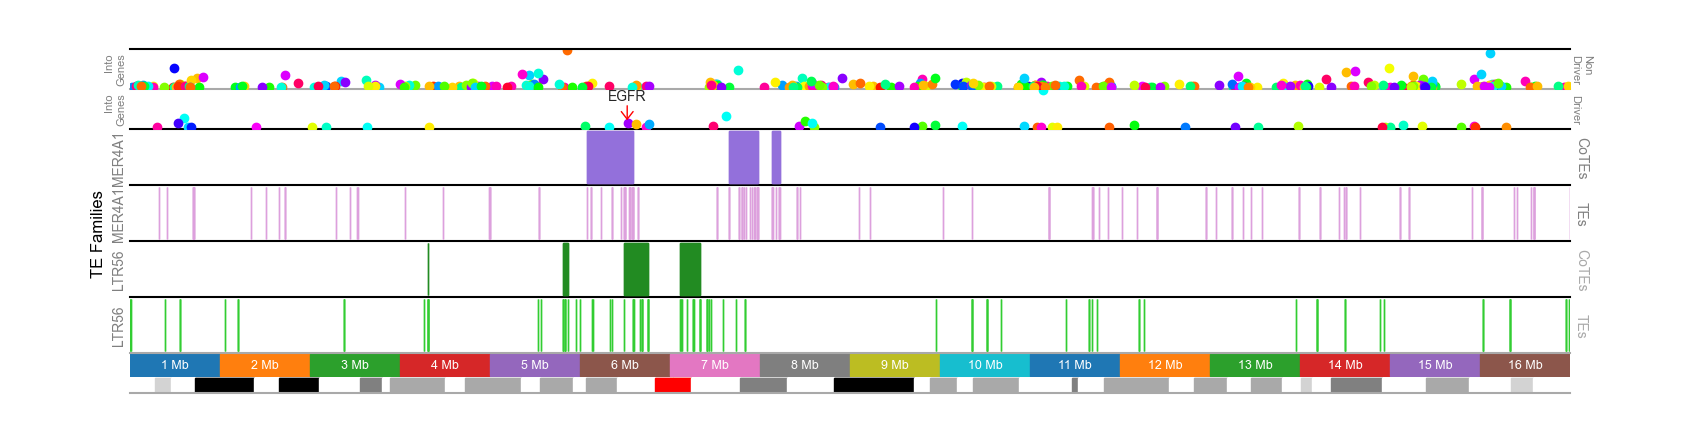

In [33]:
d = ind.chr.get_layer('TEs', chrom='chr7')

p = StackPlot(figsize=(16, 8), chromosome='chr7', left_margin=0.05, right_margin=0.05, top_margin=0)

t0 = p.add_bed((0, 2), './analysis/figures/figure 1/cytoBand.txt', 'cytoband', borders=['bottom'], border_colors={'bottom':'darkgrey', 'top':'darkgrey'}, xticks=False)
t0.view_regions(cyto=True)

t1 = p.add_track((2, 5), 'mbp', borders=['top'], border_colors={'top':'darkgrey'})
t1.rectplot(num=16, text='order', text_color='white', text_suffix=' Mb', text_fontsize=9)

t2 = p.add_bed((5, 12), '/Users/mossishahi/Code/lupien/IntData/data/V2-TEs/TEs/813_LTR56_Merged.bed', 'CoTEs - LTR56', borders=['top'])
t2.add_label('LTR56', fontsize=10, h_align='right', v_align='bottom', rotation=90, color='grey')
t2.add_label('TEs', fontsize=10, h_align='left', v_align='bottom', side='right', rotation=270,color='darkgrey')
t2.view_regions(color='limegreen')

t3 = p.add_bed((12, 19), '/Users/mossishahi/Code/lupien/IntData/data/V2-TEs/CoTEs/813_LTR56_Merged.bed', 'CoTEs - LTR56', borders=['top'])
t3.add_label('LTR56', fontsize=10, h_align='right', v_align='bottom', rotation=90, color='grey')
t3.add_label('CoTEs', fontsize=10, h_align='left', v_align='bottom', side='right', rotation=270, color='darkgrey')
t3.view_regions(color='forestgreen')

t4 = p.add_bed((19, 26), '/Users/mossishahi/Code/lupien/IntData/data/V2-TEs/TEs/1002_MER4A1_Merged.bed', 'CoTEs - LTR56', borders=['top'])
t4.add_label('MER4A1', fontsize=10, h_align='right', v_align='bottom', rotation=90, color='grey')
t4.add_label('TEs', fontsize=10, h_align='left', v_align='bottom', rotation=270, color='grey', side='right')
t4.view_regions(color='plum')

t5 = p.add_bed((26, 33), '/Users/mossishahi/Code/lupien/IntData/data/V2-TEs/CoTEs/1002_MER4A1_Merged.bed', 'mer4a1', borders=['top'])
t5.add_label('MER4A1', fontsize=10, h_align='right', v_align='bottom', rotation=90, color='grey')
t5.add_label('CoTEs', fontsize=10, h_align='left', v_align='bottom', rotation=270, color='grey', side='right')
t5.view_regions(color='mediumpurple')

# t6 = p.add_bed((33, 40), '/Users/mossishahi/Code/lupien/IntData/data/V2-TEs/TEs/129_AluYk3_Merged.bed', 'alu', borders=['top'])
# t6.add_label('AluYk3', fontsize=10, h_align='right', v_align='bottom', rotation=90, color='grey')
# t6.add_label('TEs', fontsize=10, h_align='left', v_align='bottom', rotation=270, color='grey', side='right')
# t6.view_regions(color='navajowhite')

# t7 = p.add_bed((40, 47), '/Users/mossishahi/Code/lupien/IntData/data/V2-TEs/CoTEs/129_AluYk3_Merged.bed', 'alu', borders=['top'])
# t7.add_label('AluYk3', fontsize=10, h_align='right', v_align='bottom', rotation=90, color='grey')
# t7.add_label('CoTEs', fontsize=10, h_align='left', v_align='bottom', rotation=270, color='grey', side='right')
# t7.view_regions(color='gold')

# t8 = p.add_bed((47, 54), '/Users/mossishahi/Code/lupien/IntData/data/V2-TEs/TEs/287_Charlie10_Merged.bed', 'alu', borders=['top'])
# t8.add_label('Charlie10', fontsize=9, h_align='right', v_align='bottom', rotation=90, color='grey')
# t8.add_label('TEs', fontsize=10, h_align='left', v_align='bottom', rotation=270, color='grey', side='right')
# t8.view_regions(color='skyblue')

# t9 = p.add_bed((54, 61), '/Users/mossishahi/Code/lupien/IntData/data/V2-TEs/CoTEs/287_Charlie10_Merged.bed', 'alu', borders=['top'])
# t9.add_label('Charlie10', fontsize=9, h_align='right', v_align='bottom', rotation=90, color='grey')
# t9.add_label('CoTEs', fontsize=10, h_align='left', v_align='bottom', rotation=270, color='grey', side='right')
# t9.view_regions(color='steelblue')

t10 = p.add_track((33, 38), 'driveri_genes', borders=['top'], border_colors={'top':'darkgrey'})
t10.scatterplot(driver_rectangles, hue=driver_colors)
t10.add_label('Into\nGenes', fontsize=8, h_align='right', v_align='bottom', rotation=90, color='grey', side='left')
t10.add_label('Driver', fontsize=8, h_align='left', v_align='bottom', rotation=270, color='grey', side='right')
t10.annotate([(8, "EGFR")], fontsize=10)
t11 = p.add_track((38, 43), 'driver_genes', borders=['top'])
t11.add_label('Into\nGenes', fontsize=8, h_align='right', v_align='bottom', rotation=90, color='grey', side='left')
t11.add_label('Non\nDriver', fontsize=8, h_align='left', v_align='bottom', rotation=270, color='grey', side='right')
t11.scatterplot(notdriver_rectangles, hue=notdriver_colors)
p.add_ylabel('TE Families', height=.2, start=.035, fontsize=12)
p.render()
p.fig.savefig('/Users/mossishahi/Code/lupien/IntData/analysis/figures/figure 1/fig1-panel1.png', bbox_inches='tight', dpi=600)

In [13]:
def CoTE_family(chromosome_layer, **kwargs):
    conditions = {}
    annotations = {}    
    ann = {i:te.split('>')[-1] for i, te in enumerate(ind.chr.layers[1e06]['CoTEs']['index'][1])}
    con = {te.split('>')[-1]:i for i, te in enumerate(ind.chr.layers[1e06]['CoTEs']['index'][1])}
    for chr in range(1, 25):
        conditions[chr] = np.array([con[i.split('>')[-1]] for i in chromosome_layer['index'][chr]])
        annotations[chr] = ann
    return conditions, annotations

In [14]:
ind.chr.add_filter('te_family', TE_family, ['TEs'])
ind.chr.add_filter('cote_family', CoTE_family, ['CoTEs'])